# 🧪 Group6_Project: California Google Local Business Analysis with PyMongo + Spark
This lab simulates a real-world big data pipeline using **MongoDB**, **PySpark**, and the **California Google Local Business Dataset**.
We'll:
- Insert data into MongoDB from JSON
- Load that data into Spark
- Perform analysis
- Save results back to MongoDB


## 📥 Step 1: Insert Google Local Data into MongoDB

In [207]:
import json
from pymongo import MongoClient
from pyspark.sql.functions import col

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["group6_bigdata"]

# Drop old collections if they exist
db["meta"].drop()
db["review"].drop()

# === Trim and load only first 100000 businesses ===
with open("meta-California.json", "r", encoding="utf-8") as f:
    meta_data = [json.loads(line) for _, line in zip(range(100000), f)]
db["meta"].insert_many(meta_data)
print(f"✅ Inserted {len(meta_data)} meta")

# === Trim and load only first 500000 reviews ===
with open("review-California_10.json", "r", encoding="utf-8") as f:
    review_data = [json.loads(line) for _, line in zip(range(500000), f)]
db["review"].insert_many(review_data)
print(f"✅ Inserted {len(review_data)} reviews")


✅ Inserted 100000 meta
✅ Inserted 500000 reviews


## ⚙️ Step 2: Start Spark Session

In [208]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("group6_bigdata").getOrCreate()

## 📊 Step 3: Load Data

In [209]:
# assign typeValue for each feature of meta_dataset

from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, ArrayType

schema_meta = StructType([
    StructField("name", StringType(), True),
    StructField("gmap_id", StringType(), True),
])


In [210]:
# assign typeValue for each feature of reviews_dataset
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType

schema_review = StructType([
    StructField("gmap_id", StringType(), True),
    StructField("rating", IntegerType(), True),
    StructField("text", StringType(), True),
])


In [211]:
import re
def safe_str(x, max_length=200):
    try:
        s = str(x)
        s = re.sub(r"[^\x00-\x7F]+", "", s)
        return s[:max_length]
    except:
        return ""

In [212]:
#clean data in the case data has multiple types

# for meta_dataset
def clean_meta_doc(doc):

    return {
        "name": safe_str(doc.get("name", None)),
        "gmap_id": safe_str(doc.get("gmap_id", None)),
    }


In [213]:
# for reviews_dataset
def clean_review_doc(doc):
    
    def to_int(val):
        try:
            return int(val)
        except (TypeError, ValueError):
            return None

    return {
        "gmap_id": doc.get("gmap_id", None),  # Use None for missing values
        "rating": to_int(doc.get("rating", 0)),
        "text": safe_str(doc.get("text", None)),
    }


In [214]:
from pyspark.sql.functions import col

meta_docs = list(db["meta"].find({}, {"_id": 0}))
cleaned_meta_docs = [clean_meta_doc(doc) for doc in meta_docs]
df_meta = spark.createDataFrame(cleaned_meta_docs, schema=schema_meta)
df_meta = df_meta.withColumnRenamed("name", "business_name")
df_meta.show(3, truncate=False)


+-------------+-------------------------------------+
|business_name|gmap_id                              |
+-------------+-------------------------------------+
|City Textile |0x80c2c98c0e3c16fd:0x29ec8a728764fdf9|
|San Soo Dang |0x80c2c778e3b73d33:0xbdc58662a4a97d49|
|Nova Fabrics |0x80c2c89923b27a41:0x32041559418d447 |
+-------------+-------------------------------------+
only showing top 3 rows



In [215]:
from pyspark.sql.functions import col

review_docs = list(db["review"].find({}, {"_id": 0}))
cleaned_review_docs = [clean_review_doc(doc) for doc in review_docs]
df_review = spark.createDataFrame(cleaned_review_docs, schema=schema_review)
df_review.show(3, truncate=True)

+--------------------+------+--------------------+
|             gmap_id|rating|                text|
+--------------------+------+--------------------+
|0x80c2c778e3b73d3...|     5|Love there korean...|
|0x80c2c778e3b73d3...|     5|      Good very good|
|0x80c2c778e3b73d3...|     4|They make Korean ...|
+--------------------+------+--------------------+
only showing top 3 rows



## 🔎 Step 4: Join and Analyze in Spark

In [216]:
from pyspark.sql.functions import col
df_joined = df_meta.join(df_review, on="gmap_id", how="inner")
df_joined.show(3, truncate=True)

+--------------------+--------------------+------+--------------------+
|             gmap_id|       business_name|rating|                text|
+--------------------+--------------------+------+--------------------+
|0x80946812fffffff...|Central Valley Es...|     5|Great people and ...|
|0x80946812fffffff...|Central Valley Es...|     5|Great people and ...|
|0x80946812fffffff...|Central Valley Es...|     5|Great bunch of pe...|
+--------------------+--------------------+------+--------------------+
only showing top 3 rows



In [217]:
# cache the DataFrame to optimize performance.
df_joined = df_joined.cache()
df_joined.count()

525386

In [218]:
# Calculate the average rating and the top 10 businesses

from pyspark.sql.functions import avg, count

df_avg = df_joined.groupBy("gmap_id", "business_name") \
    .agg(
        avg("rating").alias("avg_rating"),
        count("rating").alias("review_count")
    ) \
    .orderBy("avg_rating", ascending=False)

top10 = df_avg.limit(10).collect()
print(top10)

[Row(gmap_id='0x80dd33d153ddc8c9:0x7dbda3563f2ddaeb', business_name='Brazilian Top Team Long Beach Jiu-Jitsu & MMA', avg_rating=5.0, review_count=10), Row(gmap_id='0x80d954c2d2aa65ad:0x946e698976b0a9b4', business_name='F45 Training East Hillcrest', avg_rating=5.0, review_count=11), Row(gmap_id='0x80db8dc7d5fd574b:0x2b0fef413a643506', business_name='Paradise Ridge Pet Clinic', avg_rating=5.0, review_count=16), Row(gmap_id='0x80c353076de19d95:0x9d5d73f219e38530', business_name='MCG Service LLC', avg_rating=5.0, review_count=10), Row(gmap_id='0x808581752a4d40f3:0xf30a63b973cf8c83', business_name="Soft Park - Levi's Plaza", avg_rating=5.0, review_count=11), Row(gmap_id='0x80c2dabe49b7fe5b:0x87d7892c3ec5fba3', business_name='sumi beauty station', avg_rating=5.0, review_count=12), Row(gmap_id='0x80dc71c4460545af:0xdf62ebaa8d9fd334', business_name='Select German Car Service', avg_rating=5.0, review_count=18), Row(gmap_id='0x80dc6e1c6c3f008f:0xcc78287223f813df', business_name="English Tony's",

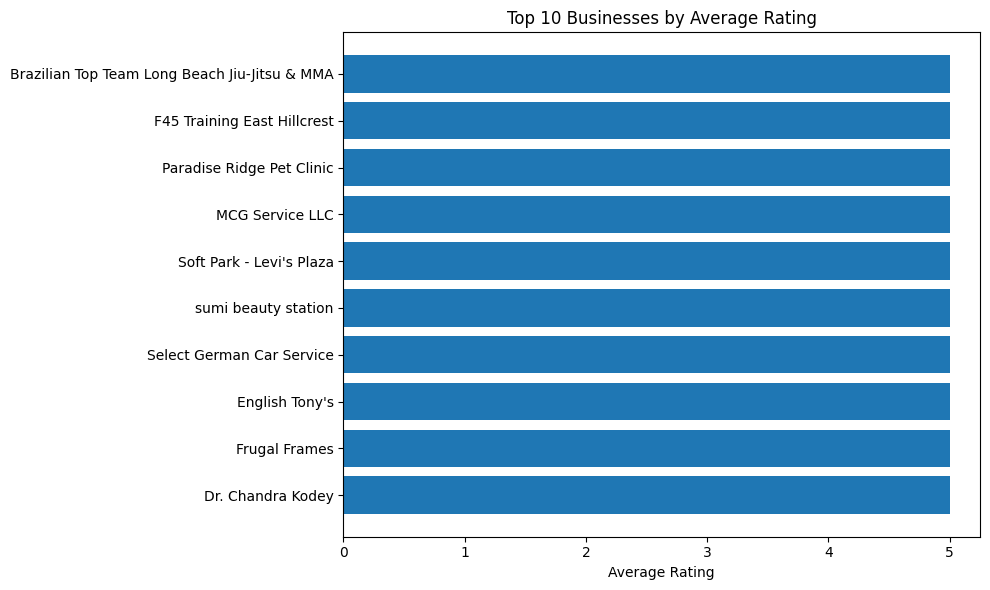

In [219]:
import matplotlib.pyplot as plt

names = [row["business_name"] for row in top10]
ratings = [row["avg_rating"] for row in top10]

plt.figure(figsize=(10, 6))
plt.barh(names[::-1], ratings[::-1])
plt.xlabel("Average Rating")
plt.title("Top 10 Businesses by Average Rating")
plt.tight_layout()
plt.show()

In [220]:
# Calculate the most reviewed businesses

from pyspark.sql.functions import count

df_most_reviewed = df_joined.groupBy("gmap_id", "business_name") \
    .agg(count("rating").alias("review_count")) \
    .orderBy("review_count", ascending=False)

top10_most_reviewed = df_most_reviewed.limit(10).collect()
print(top10_most_reviewed)

[Row(gmap_id='0x80c2bbeac4c012ef:0x1f13f07eb6cbfc6b', business_name='Rancho Park Golf Academy', review_count=489), Row(gmap_id='0x80c2c787b44f35f1:0xe0703d1f4ae40ff1', business_name='Los Angeles CDJR', review_count=372), Row(gmap_id='0x80c331470d64fe3d:0xce5bd5b605b3e0db', business_name='Tpumps', review_count=347), Row(gmap_id='0x80c2ba6b7da08fcb:0x402262c4c2f7f82e', business_name='Public Storage', review_count=288), Row(gmap_id='0x80c2c56c5e5ee8e3:0x6a98e230bfacfd11', business_name='Mandarin Noodle House', review_count=268), Row(gmap_id='0x80dc83664478ae47:0xcfe647f7a0765972', business_name='U-Haul Moving & Storage of Murrieta', review_count=232), Row(gmap_id='0x80d953c4f1984585:0x386c7c75205a5ff6', business_name='United', review_count=232), Row(gmap_id='0x80dbf9d78b59efa5:0x2ebe1c8ce4593756', business_name='U-Haul Moving & Storage of Miramar', review_count=216), Row(gmap_id='0x80843879d7a2c9e3:0x8ba3c6f64ec7abaf', business_name='Sonoma County Economic Assistance Santa Rosa', review_c

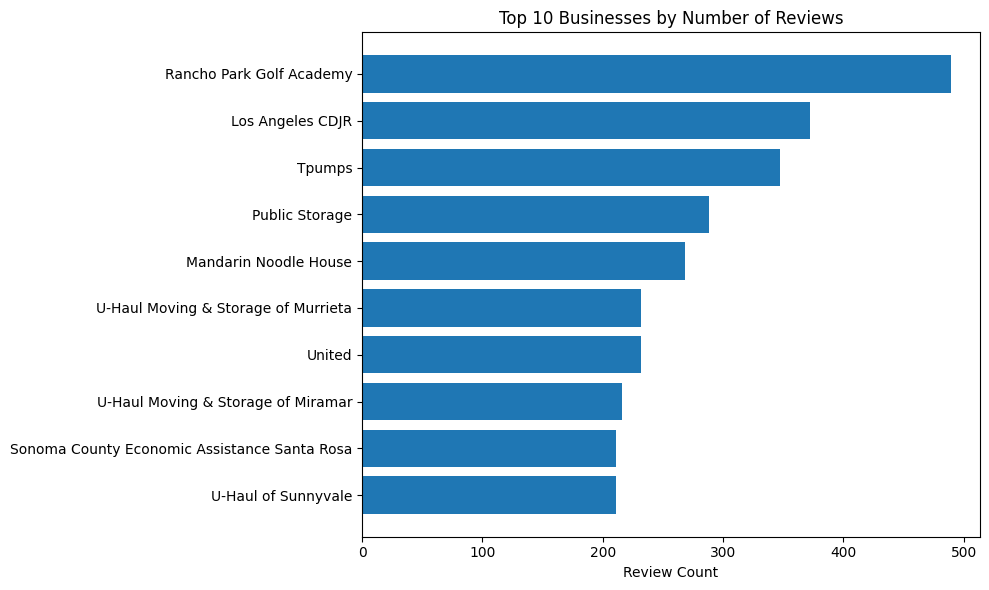

In [221]:
import matplotlib.pyplot as plt

names = [row["business_name"] for row in top10_most_reviewed]
counts = [row["review_count"] for row in top10_most_reviewed]

plt.figure(figsize=(10, 6))
plt.barh(names[::-1], counts[::-1])
plt.xlabel("Review Count")
plt.title("Top 10 Businesses by Number of Reviews")
plt.tight_layout()
plt.show()

In [222]:
# Calculate the distribution of ratings

from pyspark.sql.functions import when, count

df_buckets = df_joined.select("rating").withColumn(
    "rating_bucket",
    when((col("rating") >= 1) & (col("rating") < 2), "1-2")
    .when((col("rating") >= 2) & (col("rating") < 3), "2-3")
    .when((col("rating") >= 3) & (col("rating") < 4), "3-4")
    .when((col("rating") >= 4) & (col("rating") <= 5), "4-5")
    .otherwise("invalid")
)

df_bucket_count = df_buckets.groupBy("rating_bucket").agg(count("*").alias("count"))

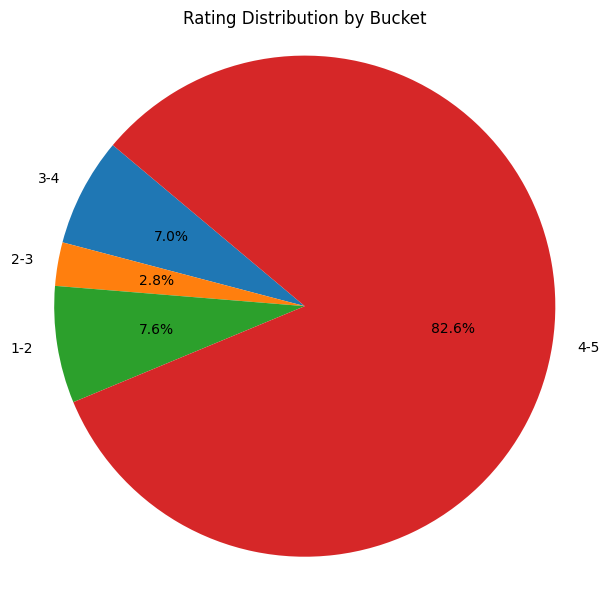

In [223]:
bucket_data = df_bucket_count.collect()

labels = [row["rating_bucket"] for row in bucket_data]
sizes = [row["count"] for row in bucket_data]

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
plt.title("Rating Distribution by Bucket")
plt.axis("equal")
plt.tight_layout()
plt.show()

In [224]:
from pyspark.sql.functions import col, explode, split, lower, regexp_extract, count

df_words = df_joined.select(
    explode(split(lower(col("text")), " ")).alias("word")
)

df_words_clean = df_words.withColumn(
    "word", regexp_extract("word", r"[a-zA-Z]{4,}", 0)
).filter(col("word") != "")

stop_words = ["the", "and", "with", "for", "you", "this", "that", "they", "restaurant", "food", "none", "very", "their"]
df_words_clean = df_words_clean.filter(~col("word").isin(stop_words))

df_word_freq = df_words_clean.groupBy("word").agg(count("*").alias("count")).orderBy(col("count").desc())

top_words = df_word_freq.limit(100).toPandas()

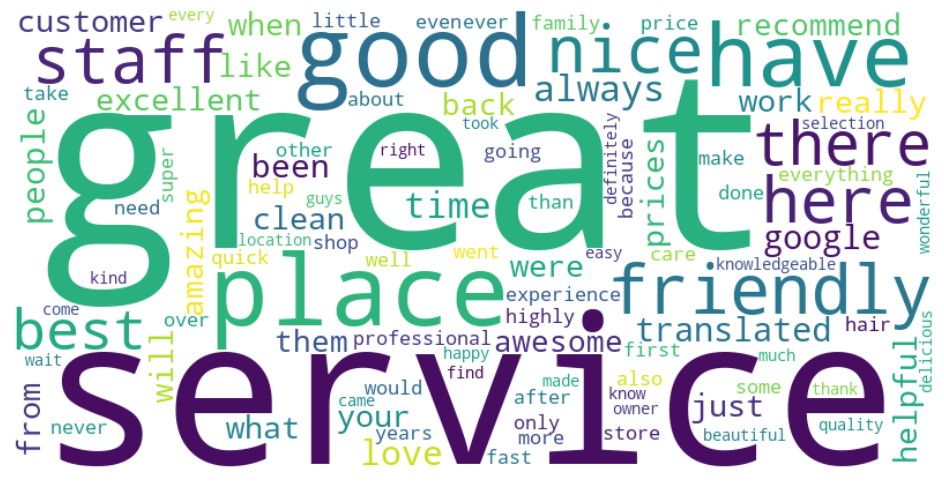

In [225]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_freq_dict = dict(zip(top_words['word'], top_words['count']))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [226]:
from pyspark.sql.functions import lower, col

# Filter reviews containing the words 'bad' or 'stay away'
filtered_reviews = df_joined.filter(
    lower(col("text")).contains("bad") | lower(col("text")).contains("stay away")
)

# Select the desired columns
filtered_reviews.select(
    "business_name", "rating", "text", 
).show(truncate=False)

+--------------------------------+------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|business_name                   |rating|text                                                                                                                                                                                                       |
+--------------------------------+------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|T-Mobile                        |1     |very bad service .. they say they open at 10:00 am and it took a long time there were several customers waiting and when they finally opened they said it would take another 20 to 30 minutes plus sever   |
|T-Mobile       

In [227]:
low_rating_reviews = df_joined.filter((col("rating") == 1) | (col("rating") == 2))

low_rating_reviews.select(
    "business_name", "text", "rating"
).show(truncate=False)

+----------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|business_name   |text                                                                                                                                                                                  |rating|
+----------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|Top Nails       |None                                                                                                                                                                                  |1     |
|Top Nails       |None                                                                                                                                              

In [228]:
filtered_specific = df_joined.filter(
    (col("business_name").contains("Beads and More"))
)

from pyspark.sql.functions import col, explode, split, lower, regexp_extract, count

df_words = filtered_specific.select(
    explode(split(lower(col("text")), " ")).alias("word")
)

df_words_clean = df_words.withColumn(
    "word", regexp_extract("word", r"[a-zA-Z]{4,}", 0)
).filter(col("word") != "")

stop_words = ["the", "and", "with", "for", "you", "this", "that", "they", "restaurant", "food"]
df_words_clean = df_words_clean.filter(~col("word").isin(stop_words))

df_word_freq = df_words_clean.groupBy("word").agg(count("*").alias("count")).orderBy(col("count").desc())

top_words = df_word_freq.limit(100).toPandas()

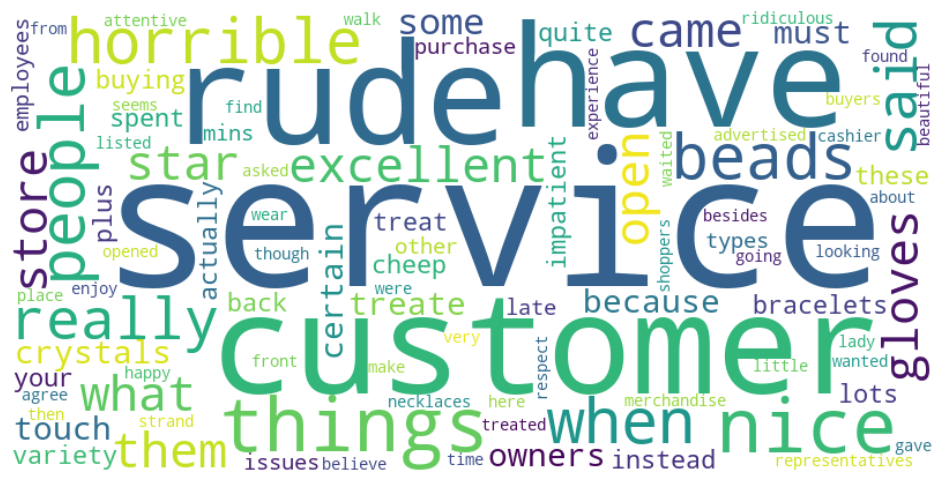

In [229]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_freq_dict = dict(zip(top_words['word'], top_words['count']))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 💾 Step 5: Save Top Businesses Back to MongoDB

In [230]:
top10_dicts = [
    {
        "gmap_id": row["gmap_id"],
        "business_name": row["business_name"],
        "avg_rating": float(row["avg_rating"]),
    }
    for row in top10
]

from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017/")
db = client["group6_bigdata"]
db["top10_avg_rating"].drop()
db["top10_avg_rating"].insert_many(top10_dicts)

InsertManyResult([ObjectId('67f8bf3e14a73b2cbddd7ba0'), ObjectId('67f8bf3e14a73b2cbddd7ba1'), ObjectId('67f8bf3e14a73b2cbddd7ba2'), ObjectId('67f8bf3e14a73b2cbddd7ba3'), ObjectId('67f8bf3e14a73b2cbddd7ba4'), ObjectId('67f8bf3e14a73b2cbddd7ba5'), ObjectId('67f8bf3e14a73b2cbddd7ba6'), ObjectId('67f8bf3e14a73b2cbddd7ba7'), ObjectId('67f8bf3e14a73b2cbddd7ba8'), ObjectId('67f8bf3e14a73b2cbddd7ba9')], acknowledged=True)

In [231]:
top10_dicts = [
    {
        "gmap_id": row["gmap_id"],
        "business_name": row["business_name"],
        "review_count": int(row["review_count"]),
    }
    for row in top10_most_reviewed
]

from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017/")
db = client["group6_bigdata"]
db["top10_review_count"].drop()
db["top10_review_count"].insert_many(top10_dicts)


InsertManyResult([ObjectId('67f8bf3e14a73b2cbddd7bab'), ObjectId('67f8bf3e14a73b2cbddd7bac'), ObjectId('67f8bf3e14a73b2cbddd7bad'), ObjectId('67f8bf3e14a73b2cbddd7bae'), ObjectId('67f8bf3e14a73b2cbddd7baf'), ObjectId('67f8bf3e14a73b2cbddd7bb0'), ObjectId('67f8bf3e14a73b2cbddd7bb1'), ObjectId('67f8bf3e14a73b2cbddd7bb2'), ObjectId('67f8bf3e14a73b2cbddd7bb3'), ObjectId('67f8bf3e14a73b2cbddd7bb4')], acknowledged=True)

In [232]:
docs = [
    {
        "bucket": row["rating_bucket"],
        "count": int(row["count"]),
    }
    for row in bucket_data
]

db["rating_distribution"].drop()
db["rating_distribution"].insert_many(docs)

InsertManyResult([ObjectId('67f8bf3e14a73b2cbddd7bb5'), ObjectId('67f8bf3e14a73b2cbddd7bb6'), ObjectId('67f8bf3e14a73b2cbddd7bb7'), ObjectId('67f8bf3e14a73b2cbddd7bb8')], acknowledged=True)

In [233]:
filtered_pd = filtered_reviews.select("business_name", "rating", "text").toPandas()


db["negative_reviews"].drop()
db["negative_reviews"].insert_many(filtered_pd.to_dict(orient="records"))

InsertManyResult([ObjectId('67f8bf3e14a73b2cbddd7bb9'), ObjectId('67f8bf3e14a73b2cbddd7bba'), ObjectId('67f8bf3e14a73b2cbddd7bbb'), ObjectId('67f8bf3e14a73b2cbddd7bbc'), ObjectId('67f8bf3e14a73b2cbddd7bbd'), ObjectId('67f8bf3e14a73b2cbddd7bbe'), ObjectId('67f8bf3e14a73b2cbddd7bbf'), ObjectId('67f8bf3e14a73b2cbddd7bc0'), ObjectId('67f8bf3e14a73b2cbddd7bc1'), ObjectId('67f8bf3e14a73b2cbddd7bc2'), ObjectId('67f8bf3e14a73b2cbddd7bc3'), ObjectId('67f8bf3e14a73b2cbddd7bc4'), ObjectId('67f8bf3e14a73b2cbddd7bc5'), ObjectId('67f8bf3e14a73b2cbddd7bc6'), ObjectId('67f8bf3e14a73b2cbddd7bc7'), ObjectId('67f8bf3e14a73b2cbddd7bc8'), ObjectId('67f8bf3e14a73b2cbddd7bc9'), ObjectId('67f8bf3e14a73b2cbddd7bca'), ObjectId('67f8bf3e14a73b2cbddd7bcb'), ObjectId('67f8bf3e14a73b2cbddd7bcc'), ObjectId('67f8bf3e14a73b2cbddd7bcd'), ObjectId('67f8bf3e14a73b2cbddd7bce'), ObjectId('67f8bf3e14a73b2cbddd7bcf'), ObjectId('67f8bf3e14a73b2cbddd7bd0'), ObjectId('67f8bf3e14a73b2cbddd7bd1'), ObjectId('67f8bf3e14a73b2cbddd7b

In [234]:
low_rating_pd = low_rating_reviews.select("business_name", "text", "rating").toPandas()

db["low_rating_reviews"].drop()
db["low_rating_reviews"].insert_many(low_rating_pd.to_dict(orient="records"))

InsertManyResult([ObjectId('67f8bf3f14a73b2cbddd9048'), ObjectId('67f8bf3f14a73b2cbddd9049'), ObjectId('67f8bf3f14a73b2cbddd904a'), ObjectId('67f8bf3f14a73b2cbddd904b'), ObjectId('67f8bf3f14a73b2cbddd904c'), ObjectId('67f8bf3f14a73b2cbddd904d'), ObjectId('67f8bf3f14a73b2cbddd904e'), ObjectId('67f8bf3f14a73b2cbddd904f'), ObjectId('67f8bf3f14a73b2cbddd9050'), ObjectId('67f8bf3f14a73b2cbddd9051'), ObjectId('67f8bf3f14a73b2cbddd9052'), ObjectId('67f8bf3f14a73b2cbddd9053'), ObjectId('67f8bf3f14a73b2cbddd9054'), ObjectId('67f8bf3f14a73b2cbddd9055'), ObjectId('67f8bf3f14a73b2cbddd9056'), ObjectId('67f8bf3f14a73b2cbddd9057'), ObjectId('67f8bf3f14a73b2cbddd9058'), ObjectId('67f8bf3f14a73b2cbddd9059'), ObjectId('67f8bf3f14a73b2cbddd905a'), ObjectId('67f8bf3f14a73b2cbddd905b'), ObjectId('67f8bf3f14a73b2cbddd905c'), ObjectId('67f8bf3f14a73b2cbddd905d'), ObjectId('67f8bf3f14a73b2cbddd905e'), ObjectId('67f8bf3f14a73b2cbddd905f'), ObjectId('67f8bf3f14a73b2cbddd9060'), ObjectId('67f8bf3f14a73b2cbddd90

## ✅ Summary
- We ingested real-world JSON data into MongoDB
- Processed it in Spark
- Wrote back results to MongoDB
- This simulates your final project in a smaller scope 🚀